# Imports

In [69]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import numpy as np

# To Extract all the URLs from the HTML page
from bs4 import BeautifulSoup
import os

#pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from urllib.parse import unquote





# Downloadings

#### Datasets

In [46]:
# Paths
folder_path = "dataset/wikispeedia_paths-and-graph/"
file_paths = ["paths_finished.tsv", "paths_unfinished.tsv", "categories.tsv", "articles.tsv", "links.tsv"]

# Datasets: Names and their columns name
data_frames_names = ["paths_finished", "paths_unfinished", "categories", "article", "links"]
dfs_headers = [
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    ["article", "category"],
    ["article"],
    ["linkSource", "linkTarget"]
]

# Download
dfs_skiprows = [16, 17, 13, 12, 12]
dfs = {}
for i in range(len(file_paths)):
    dfs[data_frames_names[i]] = pd.read_csv(folder_path + file_paths[i], sep='\t', header=None, names=dfs_headers[i], skiprows=range(dfs_skiprows[i]))

#### List of paths to access the articles htm

In [3]:
list_articles_paths = []

# Iterate through all htm file in all sub-folder from main folder wp 
for root, dirs, subfolders in os.walk('dataset/wpcd/wp/'):
    for file in subfolders:
        # Select only the htm files
        if file.endswith('.htm'):
            file_path = os.path.join(root, file)
            # Store only select the htm usefull for the game 
            if 'index' not in file_path:
                list_articles_paths.append(file_path)


# Functions

In [8]:
def extract_links(file_path):
    """It extracts all the links there is in the provided article. 
    param:
        file_path: str, path to the article we want to access.
    return:
       filtered_links: list of str, the list of all the hyperlink (only those link to another article) found in the provided article.
    """
    with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
        soup = BeautifulSoup(file, 'html.parser')

        # Get all the hyperlinks
        links = [a.get('href') for a in soup.find_all('a', href=True)]

        # Remove all the links that are not taken into account in the game (those that are not link to another article)
        filtered_links = [link for link in links if '/images/' not in link and 
                                                    'disclaimer.htm' not in link and 
                                                    'index' not in link and 
                                                    '.htm' in link]

        return filtered_links 

def change_characters(dict_df, dataset_name, column_name):
    """ It replaces the %xx escapes with their single-character equivalent for all the value of a specified column.
    param:
        dict_df: dictionnary of dataframes
        dataset_name: str, name of the dataset contain in dict_df
        column_name: str, name of the column from which we want to replace the values
    return:
        dict_df: the provided dictionnary of dataframe with the replaced characters
     """
    dict_df[dataset_name][column_name] = [unquote(art) for art in dict_df[dataset_name][column_name]]
    return dict_df

def path_to_name(path):
    """ It selects the article name from its path.
    param: 
        path: str
    return: 
        name: str, name of the article extract from the path
     """
    
    # Extract last path name of the source article
    name = os.path.basename(path)
    # Remove the extension
    name = os.path.splitext(name)[0]
    # Be sure name correctly expressed
    name = unquote(unquote(str(name)))
    
    return name



### Function examples

In [9]:
extract_links('dataset/wpcd/wp/a/ABO_blood_group_system.htm')

['../../wp/b/Blood_type.htm',
 '../../wp/a/Ape.htm',
 '../../wp/c/Chimpanzee.htm',
 '../../wp/b/Bonobo.htm',
 '../../wp/g/Gorilla.htm',
 '../../wp/b/Bacteria.htm',
 '../../wp/p/Plant.htm',
 '../../wp/e/Europe.htm',
 '../../wp/s/South_America.htm',
 '../../wp/u/United_Kingdom.htm',
 '../../wp/i/Ireland.htm',
 '../../wp/f/France.htm',
 '../../wp/h/Hong_Kong.htm',
 '../../wp/v/Vietnam.htm',
 '../../wp/g/Germany.htm',
 '../../wp/f/Finland.htm',
 '../../wp/r/Romania.htm',
 '../../wp/r/Russia.htm',
 '../../wp/j/Japan.htm',
 '../../wp/u/United_Kingdom.htm',
 '../../wp/v/Viking.htm',
 '../../wp/r/Russia.htm',
 '../../wp/w/Wikipedia_Text_of_the_GNU_Free_Documentation_License.htm']

# Pre-processing

In [47]:
# Replace all the %.. by a human-readable single-character
dfs = change_characters(dfs, 'paths_finished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'target')
dfs = change_characters(dfs, 'categories', 'article')
dfs = change_characters(dfs, 'categories', 'category')
dfs = change_characters(dfs, 'article', 'article')
dfs = change_characters(dfs, 'links', 'linkSource')
dfs = change_characters(dfs, 'links', 'linkTarget')

# Code

In [12]:
def create_connection_graph(html_files, nodes_name):
    start_time = datetime.now()
    # Create a directed graph
    graph = nx.MultiGraph() #MultiDiGraph
    #graph = Network(notebook=True)

   # for node in nodes_name:
   #     graph.add_node(node)
    
    # Iterate through HTML files and extract links
    for html_file in html_files: # For now we want just one link, later We will take into account repetition maybe ? 
 
        links = extract_links(html_file)
        # Extract the source article name
        source_name = path_to_name(html_file)

        for link in set(links):
            # Extract the reached article name
            target_name = path_to_name(link)
            #print(target_name)
            # Add edges to the graph
            graph.add_edge(source_name, target_name)

    print('Duration create_connection_graph for {} html files: {}'.format(len(html_files), datetime.now() - start_time))
    return graph

In [79]:
# Gives the main category for each articles
ategories = dfs['categories'].copy()
categories.category = [cat.split('.')[1] for cat in categories.category]
unique_categories = categories.category.unique()
# Some of them have two main categories, for now I just select the first one to appear !!! Later need to change
categories = categories.groupby('article')['category'].first().reset_index()
categories

,article,category
0,10th_century,History
1,11th_century,History
2,12th_century,History
3,13th_century,History
4,14th_century,History
...,...,...
4593,Åland,Countries
4594,Édouard_Manet,People
4595,Éire,Countries
4596,Óengus_I_of_the_Picts,History


In [80]:
connection_graph10 = create_connection_graph(list_articles_paths[:10], dfs['article']['article'])
connection_graph100 = create_connection_graph(list_articles_paths[:100], dfs['article']['article'])
connection_graph200 = create_connection_graph(list_articles_paths[:200], dfs['article']['article'])
connection_graph400 = create_connection_graph(list_articles_paths[:400], dfs['article']['article'])
connection_graph600 = create_connection_graph(list_articles_paths[:600], dfs['article']['article'])
connection_graph1000 = create_connection_graph(list_articles_paths[:1000], dfs['article']['article'])
connection_graphAll = create_connection_graph(list_articles_paths, dfs['article']['article'])

Duration create_connection_graph for 10 html files: 0:00:00.301631
Duration create_connection_graph for 100 html files: 0:00:03.296423
Duration create_connection_graph for 200 html files: 0:00:05.626638
Duration create_connection_graph for 400 html files: 0:00:11.269483
Duration create_connection_graph for 600 html files: 0:00:17.350551
Duration create_connection_graph for 1000 html files: 0:00:28.322818
Duration create_connection_graph for 5236 html files: 0:02:24.294514


In [102]:
color_dict = {cat: i for i, cat in enumerate(categories.category.unique())}
color_dict

{'History': 0,
 'Science': 1,
 'Everyday_life': 2,
 'Geography': 3,
 'Design_and_Technology': 4,
 'People': 5,
 'Music': 6,
 'IT': 7,
 'Business_Studies': 8,
 'Language_and_literature': 9,
 'Religion': 10,
 'Art': 11,
 'Countries': 12,
 'Citizenship': 13,
 'Mathematics': 14}

In [109]:
colors = sns.color_palette("colorblind", n_colors=len(categories.category.unique()))
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [111]:
colors[0]

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

In [107]:
colors[color_dict[category_dict['Art']]]

(0.8705882352941177, 0.5607843137254902, 0.0196078431372549)

In [143]:
category_dict

{'10th_century': 'History',
 '11th_century': 'History',
 '12th_century': 'History',
 '13th_century': 'History',
 '14th_century': 'History',
 '15th_Marine_Expeditionary_Unit': 'History',
 '15th_century': 'History',
 '16_Cygni': 'Science',
 '16_Cygni_Bb': 'Science',
 '16th_century': 'History',
 '1755_Lisbon_earthquake': 'History',
 '17th_century': 'History',
 '1896_Summer_Olympics': 'Everyday_life',
 '18th_century': 'History',
 '1928_Okeechobee_Hurricane': 'Geography',
 '1973_oil_crisis': 'History',
 '1980_eruption_of_Mount_St._Helens': 'Geography',
 '1997_Pacific_hurricane_season': 'Geography',
 '19th_century': 'History',
 '1_Ceres': 'Science',
 '1st_century': 'History',
 '1st_century_BC': 'History',
 '2-6-0': 'Design_and_Technology',
 '2-8-0': 'Design_and_Technology',
 '2003_Atlantic_hurricane_season': 'Geography',
 '2004_Atlantic_hurricane_season': 'Geography',
 '2004_Indian_Ocean_earthquake': 'Geography',
 '2005_Atlantic_hurricane_season': 'Geography',
 '2005_Hertfordshire_Oil_Storag

In [142]:
category_dict['Countries']

KeyError: 'Countries'

ValueError: 'c' argument has 237 elements, which is inconsistent with 'x' and 'y' with size 255.

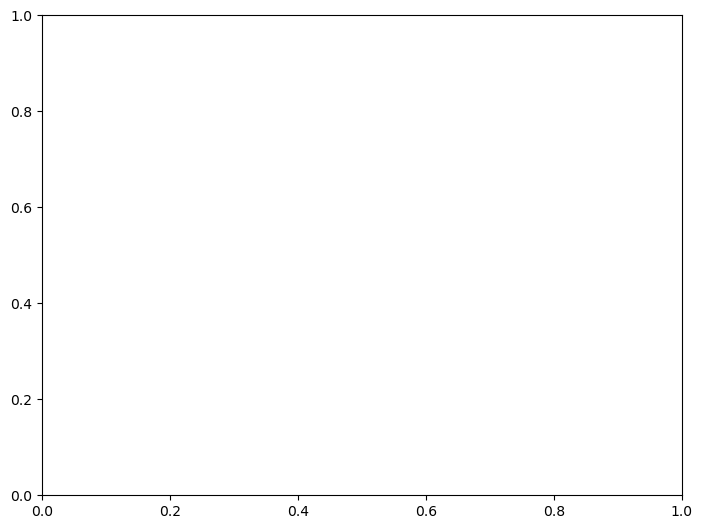

In [145]:
# Draw the graph
import seaborn as sns


colors = sns.color_palette("colorblind", n_colors=len(categories.category.unique()))
color_dict = {cat: i for i, cat in enumerate(categories.category.unique())}

g = connection_graph10

# Assign categories to nodes
category_dict = categories.set_index('article')['category'].to_dict() 
nx.set_node_attributes(g, category_dict, 'category')


colors_nodes = [colors[color_dict[v]] for node, cat in g.nodes(data = True) for k, v in cat.items()]

pos = nx.spring_layout(g)  # You can use other layout algorithms as well
nx.draw(g, pos, with_labels=False, node_size=15, node_color=colors_nodes)
plt.show()

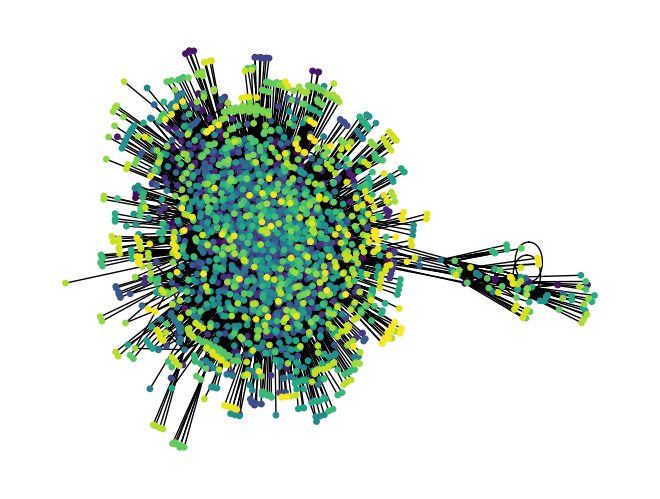

In [98]:
# Draw the graph
#plt.figure(figsize=(15, 15))
g = connection_graph400
pos = nx.spring_layout(g)  # You can use other layout algorithms as well
colors = [i/len(g.nodes) for i in range(len(g.nodes))]



nx.draw(g, pos, with_labels=False, node_size=15,  node_color=colors)
plt.show()

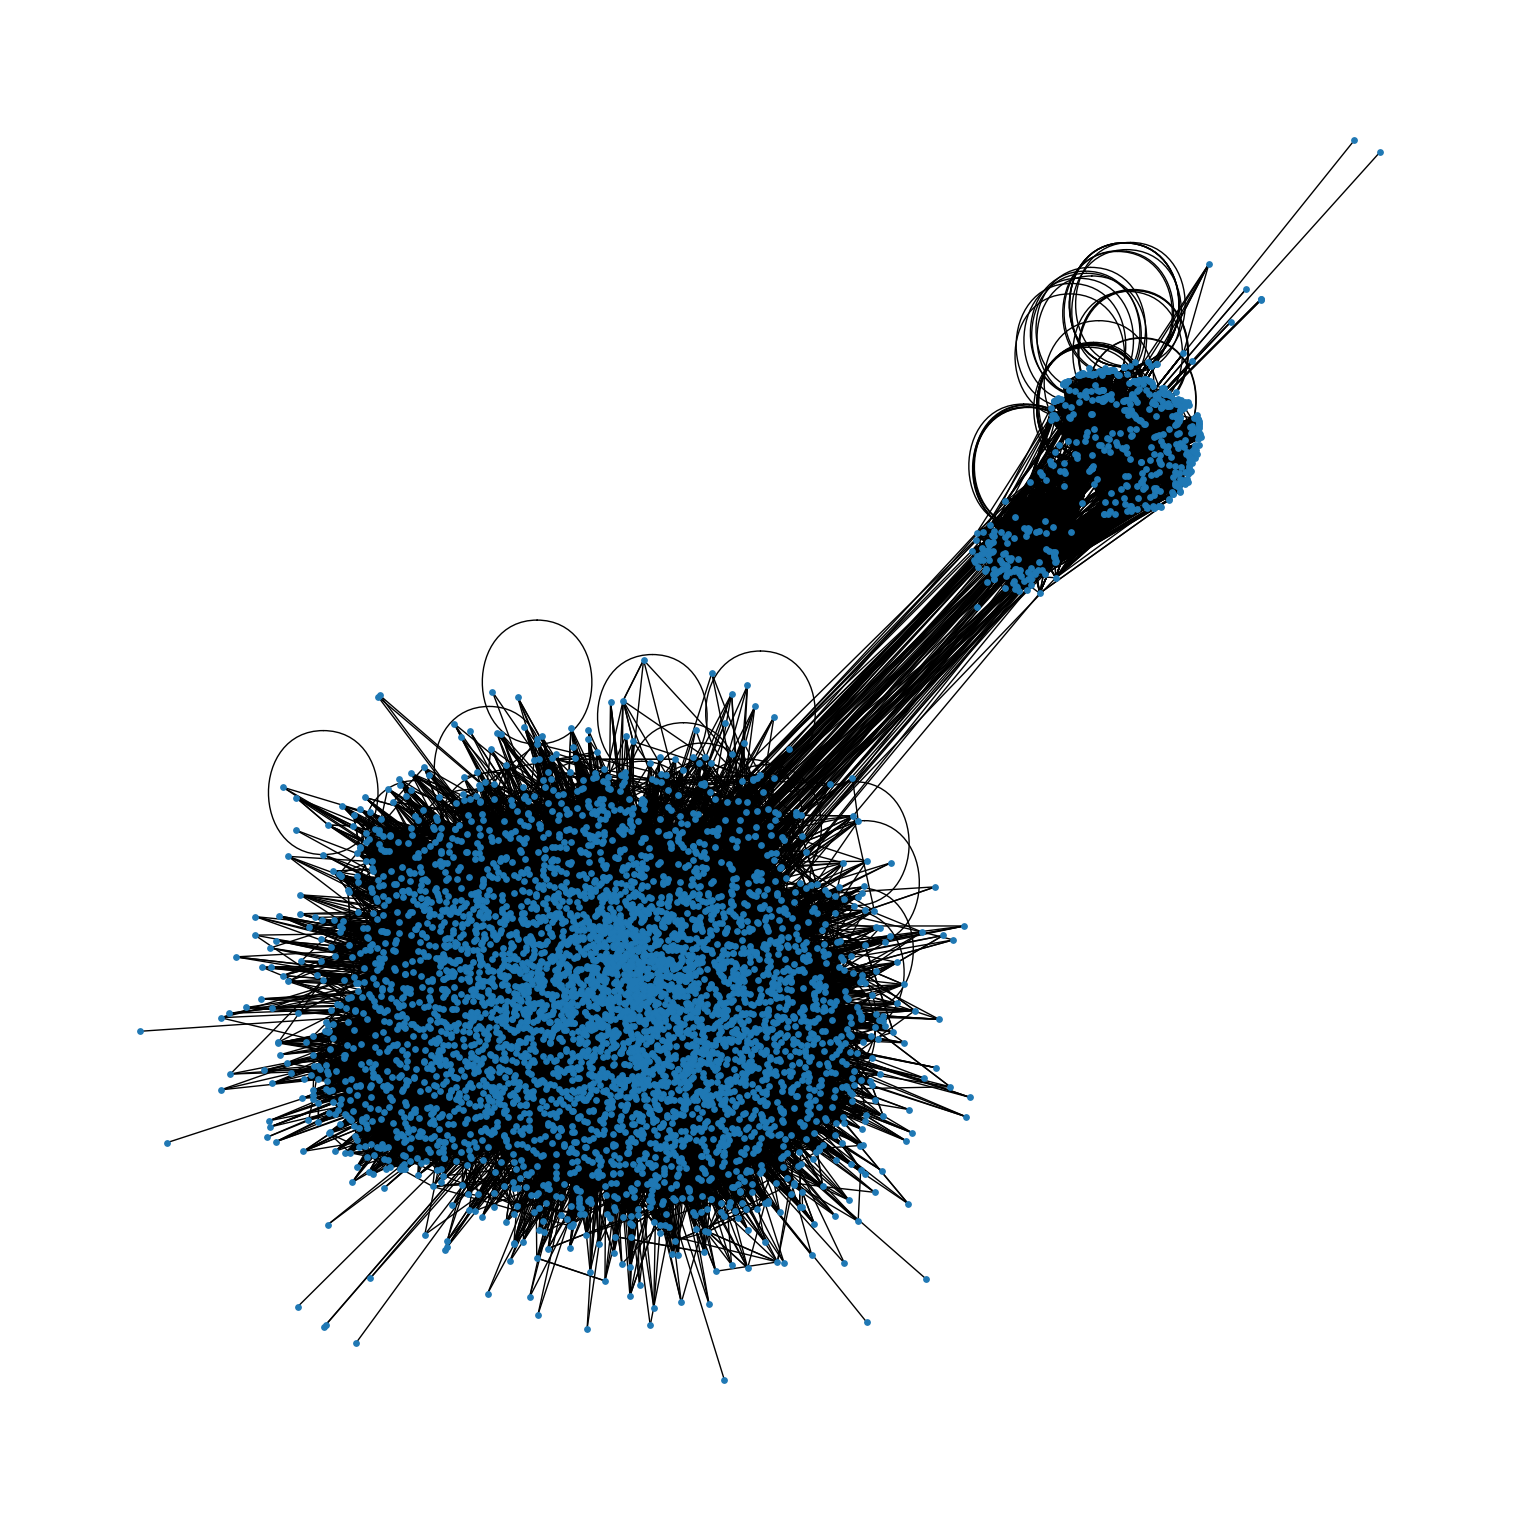

In [24]:
# Draw the graph
plt.figure(figsize=(15, 15))
g = connection_graphAll
pos = nx.spring_layout(g)  # You can use other layout algorithms as well
nx.draw(g, pos, with_labels=False, node_size=15)
plt.show()

Duration create_connection_graph: 0:00:06.164468


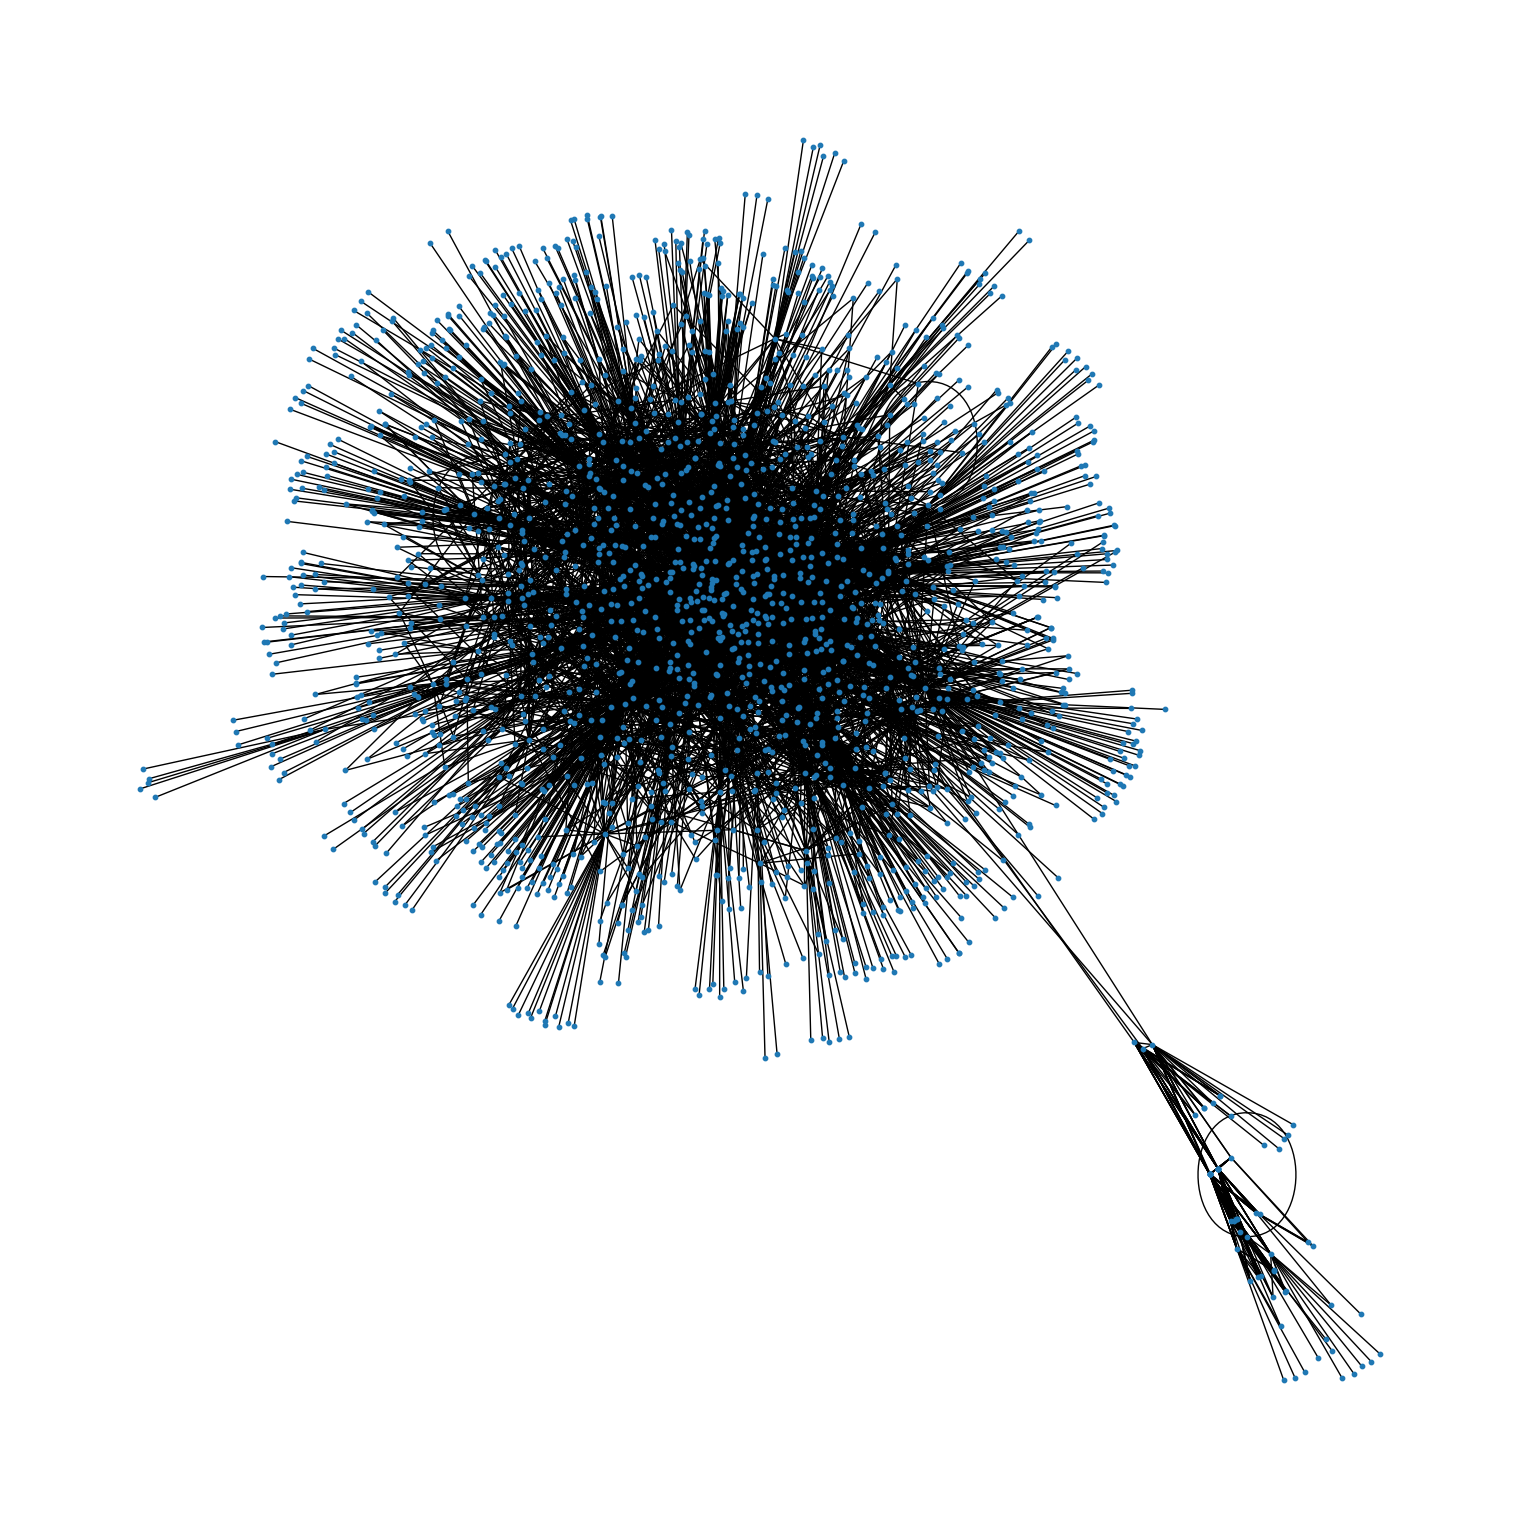

Duration draw connection graph: 0:00:19.591252


In [168]:
#nx.draw(connection_graph, with_labels=False, node_size=10)
plt.figure(figsize=(15, 15))
nx.draw_spring(connection_graph, with_labels=False, node_size=10)

#draw_kamada_kawai, draw_circular, draw_random, draw_spring, draw_shell
plt.show()
#connection_graph.show() 
